K =  1  Final loss:  16815.324
Class:  0  Percent of points:  100.0


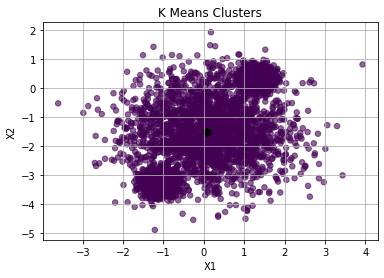

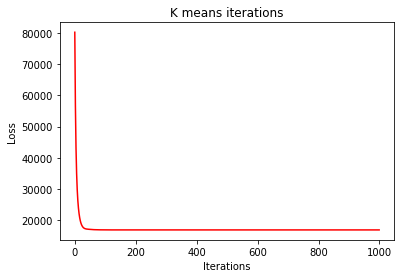

K =  2  Final loss:  8731.25
Class:  0  Percent of points:  42.47787610619469
Class:  1  Percent of points:  57.52212389380531


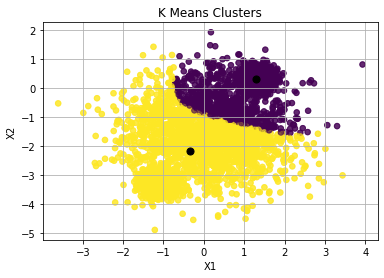

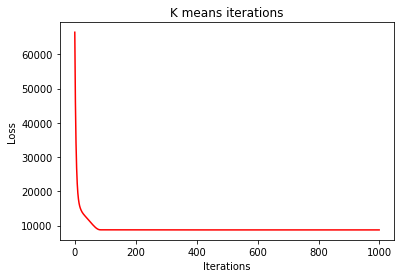

K =  3  Final loss:  2678.8733
Class:  0  Percent of points:  50.382480875956205
Class:  1  Percent of points:  38.96805159742013
Class:  2  Percent of points:  10.649467526623669


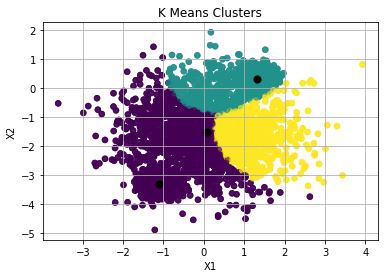

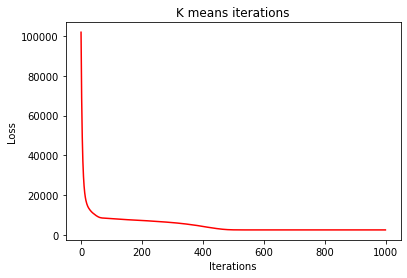

K =  4  Final loss:  2457.6064
Class:  0  Percent of points:  28.678566071696416
Class:  1  Percent of points:  6.4496775161241935
Class:  2  Percent of points:  26.158692065396732
Class:  3  Percent of points:  38.71306434678266


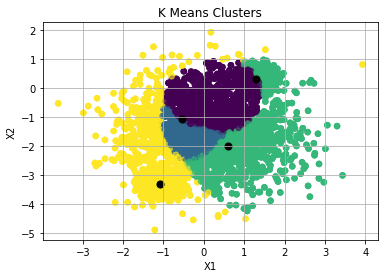

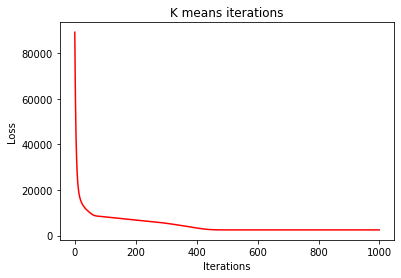

K =  5  Final loss:  2009.1537
Class:  0  Percent of points:  40.12299385030749
Class:  1  Percent of points:  6.419679016049198
Class:  2  Percent of points:  52.52737363131843
Class:  3  Percent of points:  0.7349632518374082
Class:  4  Percent of points:  0.19499025048747562


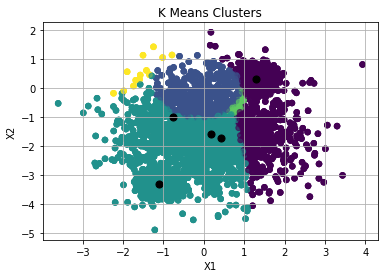

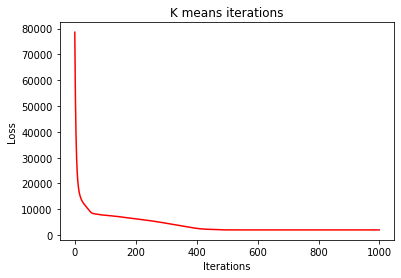

'\nvalidation.append(k_means(5))\nvalidation.append(k_means(10))\nvalidation.append(k_means(15))\nvalidation.append(k_means(20))\nvalidation.append(k_means(30))\nplt.figure(1)\n\n\nplt.plot(range(len(validation[0])), validation[0], c="r", label="K=5")\nplt.plot(range(len(validation[1])), validation[1], c="g", label="K=10")\nplt.plot(range(len(validation[2])), validation[2], c="b", label="K=15")\nplt.plot(range(len(validation[3])), validation[3], c="m", label="K=20")\nplt.plot(range(len(validation[4])), validation[4], c="y", label="K=30")\n\nplt.title("Validation loss for different K\'s")\nplt.xlabel("Iterations")\nplt.ylabel("Loss")\nplt.legend()\n#plt.plot(validation)\nplt.show()\n\n'

In [2]:
#import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import helper as hlp
from collections import Counter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



# For Validation set
is_valid = True




def distance_func(X, mu):
    """ Inputs:
            X: is an NxD matrix (N observations and D dimensions)
            mu: is an KxD matrix (K means and D dimensions)
        Outputs
            pair_dist: is the pairwise distance matrix (NxK)
    """
    X = tf.expand_dims(X, 0)
    mu = tf.expand_dims(mu, 1)
    pair_dist = tf.reduce_sum(tf.square(tf.subtract(X, mu)), 2)
    # returns KxN so transpose it because we need NxK
    return tf.transpose(pair_dist)


def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """
    x_mu = distance_func(X, mu)
    x_mu = tf.multiply(x_mu, x_mu)
    sigma = tf.squeeze(sigma)
    second_term = x_mu/(2*sigma)
    first_term = tf.log(2*np.pi*sigma) * tf.to_float(tf.rank(X))
    pdf = -0.5*first_term - second_term
    return pdf


def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    logPI = tf.squeeze(log_pi)
    logP = tf.add(logPI, log_PDF)
    logSummation = hlp.reduce_logsumexp(log_PDF + logPI, keep_dims=True)
    final = logP - logSummation
    return final



def k_means(K):
  # Loading data
  #data = np.load('data100D.npy')
  data = np.load('data2D.npy')
  [num_pts, dim] = np.shape(data)

  if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]

  np.random.seed(777)
  loss_array = []
  loss_array_val = []

  N = num_pts
  D = dim
  iterations = 1000
  assignments = []

  learning_rt = 0.1
  std_dev= 0.1

  # create x as a placeholder (nonexD)
  X = tf.placeholder("float", [None, D], "X")
  # need standard distributions values (KxD)
  mu_std = tf.random_normal([K, D], stddev=std_dev)
  mu = tf.Variable(mu_std)
  
  # sigma is Kx1- given
  sigma = tf.Variable(tf.random_normal([K, 1], stddev = std_dev))
  sigma = tf.exp(sigma)

  logPDF = log_gauss_pdf(X, mu, sigma)
  pi = tf.Variable(tf.random_normal([K, 1], stddev= std_dev))
  logpi = tf.squeeze(hlp.logsoftmax(pi)) # use softmax fxn for constraint
  # following equation given in assignment
  loss = hlp.reduce_logsumexp(logPDF + logpi, 1, keep_dims=True)
  loss = -tf.reduce_sum(loss)

  # using adamOptimizer as stated in handout
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rt, beta1 = 0.9, beta2 = 0.99, epsilon=1e-5).minimize(loss)

  # find the clusters
  # P(z=k|x)
  predicted_cluster = tf.argmax(tf.nn.softmax(log_posterior(logPDF, logpi)), 1)
  globals_init = tf.global_variables_initializer()
  locals_init = tf.local_variables_initializer()

  with tf.Session() as sess:
    sess.run(globals_init)
    sess.run(locals_init)

    for i in range(iterations):
      if is_valid:
        center_val, loss_curr_val, opt_val, assignments =  sess.run([mu, loss, optimizer, predicted_cluster], feed_dict={X:val_data})
        loss_array_val.append(loss_curr_val)
      
      else:
        center, loss_curr, opt, assignments = sess.run([mu, loss, optimizer, predicted_cluster], feed_dict={X:data})
        loss_array.append(loss_curr)
      
    
    #print("K = ", K, " Final loss: ", loss_array[-1])
    print("K = ", K, " Final loss: ", loss_array_val[-1])
    
    
    # empty array of zeros of size K which will store the % of points belonging to the clusters
    
    percents = np.zeros(K)
    #assignments = np.int32(assignments)
    for j in range(K):
      # will check which point belongs to the jth cluster and adds it to running total and divided by len for %
      percents[j] = np.sum(np.equal(j, assignments))*100.00/len(assignments)
      print("Class: ", j, " Percent of points: ", percents[j])
      #plt.scatter(data[:, 0], data[:, 1], c=assignments, s=30, alpha=0.6)
      plt.scatter(val_data[:, 0], val_data[:, 1], c=assignments, s=30, alpha=0.6)
    

    
    #plt.scatter(center[:, 0], center[:, 1], c="black", s=80)
    plt.scatter(center_val[:, 0], center_val[:, 1], c="black", s=50)
    plt.title("K Means Clusters")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid()
    plt.show()

  plt.figure(1)
  #plt.plot(range(len(loss_array)), loss_array, c="c", label="training loss")
  plt.plot(range(len(loss_array_val)), loss_array_val, c="r", label="validation loss")
  
  plt.title("K means iterations")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  #return loss_array
  return loss_array_val




validation = []

validation.append((k_means(1))[-1])
validation.append((k_means(2))[-1])
validation.append((k_means(3))[-1])
validation.append((k_means(4))[-1])
validation.append((k_means(5))[-1])

'''
validation.append(k_means(5))
validation.append(k_means(10))
validation.append(k_means(15))
validation.append(k_means(20))
validation.append(k_means(30))
plt.figure(1)


plt.plot(range(len(validation[0])), validation[0], c="r", label="K=5")
plt.plot(range(len(validation[1])), validation[1], c="g", label="K=10")
plt.plot(range(len(validation[2])), validation[2], c="b", label="K=15")
plt.plot(range(len(validation[3])), validation[3], c="m", label="K=20")
plt.plot(range(len(validation[4])), validation[4], c="y", label="K=30")

plt.title("Validation loss for different K's")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
#plt.plot(validation)
plt.show()

'''



In [ ]:
#import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import helper as hlp
from collections import Counter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.__version__

'2.8.0'